In [3]:
import requests
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as nd
import tensorflow as tf
import tensorflow_hub as hub
from google_images_download import google_images_download
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
# from skimage.feature import plot_matches
# from skimage.filters import gaussian
# from skimage.measure import ransac
# from skimage.transform import AffineTransform
# from skimage import color, io
# from skimage.exposure import rescale_intensity


In [4]:
module = hub.Module("https://tfhub.dev/google/imagenet/resnet_v1_50/classification/1")
height, width = hub.get_expected_image_size(module)
height, width

(224, 224)

In [6]:
response = google_images_download.googleimagesdownload()
arguments = {"keywords": "animal national park", "limit": 20,
             "print_urls": True}
absolute_image_paths = response.download(arguments)


Item no.: 1 --> Item name = animal national park
Evaluating...
Starting Download...
Image URL: https://i.ytimg.com/vi/P8NJa_YoRxk/maxresdefault.jpg
Completed Image ====> 1.maxresdefault.jpg
Image URL: https://k6u8v6y8.stackpathcdn.com/blog/wp-content/uploads/2014/04/national-parks-and-wildlife-sanctuaries-in-india.png
Completed Image ====> 2.national-parks-and-wildlife-sanctuaries-in-india.png
Image URL: https://upload.wikimedia.org/wikipedia/commons/5/54/Nairobi_National_Park%2C_Kenya_%2832570316676%29.jpg
Completed Image ====> 3.Nairobi_National_Park%2C_Kenya_%2832570316676%29.jpg
Image URL: https://www.kideponationalpark.com/wp-content/uploads/2016/11/zebras-in-kidepo-750x450.jpg
Completed Image ====> 4.zebras-in-kidepo-750x450.jpg
Image URL: https://k6u8v6y8.stackpathcdn.com/blog/wp-content/uploads/2017/06/Royal-Bengal-Tiger.jpg
Completed Image ====> 5.Royal-Bengal-Tiger.jpg
Image URL: https://www.corbettnationalpark.in/blog/wp-content/uploads/2015/08/cropped-13625772024_1fd7467d2

In [7]:
image_list = absolute_image_paths[0]['animal national park']
image_list

['C:\\Users\\mhdal\\github\\DS-Unit-4-Sprint-3-Deep-Learning\\module2-convolutional-neural-networks\\downloads\\animal national park\\1.maxresdefault.jpg',
 'C:\\Users\\mhdal\\github\\DS-Unit-4-Sprint-3-Deep-Learning\\module2-convolutional-neural-networks\\downloads\\animal national park\\2.national-parks-and-wildlife-sanctuaries-in-india.png',
 'C:\\Users\\mhdal\\github\\DS-Unit-4-Sprint-3-Deep-Learning\\module2-convolutional-neural-networks\\downloads\\animal national park\\3.Nairobi_National_Park%2C_Kenya_%2832570316676%29.jpg',
 'C:\\Users\\mhdal\\github\\DS-Unit-4-Sprint-3-Deep-Learning\\module2-convolutional-neural-networks\\downloads\\animal national park\\4.zebras-in-kidepo-750x450.jpg',
 'C:\\Users\\mhdal\\github\\DS-Unit-4-Sprint-3-Deep-Learning\\module2-convolutional-neural-networks\\downloads\\animal national park\\5.Royal-Bengal-Tiger.jpg',
 'C:\\Users\\mhdal\\github\\DS-Unit-4-Sprint-3-Deep-Learning\\module2-convolutional-neural-networks\\downloads\\animal national park\\

In [17]:
image_list = image_list[:17]

In [18]:
height, width = hub.get_expected_image_size(module)

def resize_image(filename, new_width=height, new_height=width):
    pil_image = Image.open(filename)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert('RGB')
    pil_image_rgb.save(filename, format='JPEG', quality=90)
#     print(filename)
    return filename

In [19]:
images = [resize_image(image) for image in image_list]
images

['C:\\Users\\mhdal\\github\\DS-Unit-4-Sprint-3-Deep-Learning\\module2-convolutional-neural-networks\\downloads\\animal national park\\1.maxresdefault.jpg',
 'C:\\Users\\mhdal\\github\\DS-Unit-4-Sprint-3-Deep-Learning\\module2-convolutional-neural-networks\\downloads\\animal national park\\2.national-parks-and-wildlife-sanctuaries-in-india.png',
 'C:\\Users\\mhdal\\github\\DS-Unit-4-Sprint-3-Deep-Learning\\module2-convolutional-neural-networks\\downloads\\animal national park\\3.Nairobi_National_Park%2C_Kenya_%2832570316676%29.jpg',
 'C:\\Users\\mhdal\\github\\DS-Unit-4-Sprint-3-Deep-Learning\\module2-convolutional-neural-networks\\downloads\\animal national park\\4.zebras-in-kidepo-750x450.jpg',
 'C:\\Users\\mhdal\\github\\DS-Unit-4-Sprint-3-Deep-Learning\\module2-convolutional-neural-networks\\downloads\\animal national park\\5.Royal-Bengal-Tiger.jpg',
 'C:\\Users\\mhdal\\github\\DS-Unit-4-Sprint-3-Deep-Learning\\module2-convolutional-neural-networks\\downloads\\animal national park\\

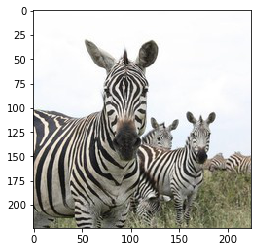

In [20]:
plt.imshow(np.asarray(Image.open(images[11])))

In [21]:
real_images = np.array([np.asarray(Image.open(image)) / 255 for image in images])
real_images.shape

(17, 224, 224, 3)

In [22]:
real_images.shape

(17, 224, 224, 3)

In [23]:
logits = module(real_images)

In [24]:
target_map = requests.get('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt').content

In [ ]:
str(target_map).split('\\n')

In [27]:
lookup = [target.strip(r"'b'").strip(r'"') for target in str(target_map).split('\\n')]

In [ ]:
lookup

In [28]:
logits[4]

<tf.Tensor 'strided_slice:0' shape=(1001,) dtype=float32>

In [32]:
lookup[np.argmax(logits[1])]

'background'

0